In [911]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

In [879]:
df = pd.read_csv(filepath_or_buffer="stroke_data.csv", sep=",", header=0)
df_raw = df.copy()

In [880]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 1. Data analysis

## 1.1 General exploration
We are going to check the type of data, the defining statistics and the missing values


We observe **4 discrete variables** (int64) with our target variable **stroke** inside them, **3 continuous variables** (float64) and **5 variables** that as labels or factors (object) 

From the 12 variables, can say that we will have 11 explanatory variables and 1 output variable (**stroke**)

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.describe(exclude=[np.number])

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


In [6]:
df.select_dtypes("object").columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [7]:
# Print the values of the non-numerical variables
print(df.gender.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.Residence_type.unique())
print(df.smoking_status.unique())
# We should make a conversion of these variables into a numerical value

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [8]:
# Print the values of the non-numerical variables
print(df.gender.value_counts())
print(df.ever_married.value_counts())
print(df.work_type.value_counts())
print(df.Residence_type.value_counts())
print(df.smoking_status.value_counts())
# We observe more male than females in the sample

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
ever_married
Yes    3353
No     1757
Name: count, dtype: int64
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


In [9]:
df.describe()
# We can guess that there are some missing values on the bmi (body mass index) variable

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We found missing values only on the BMI variable 

In [10]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

We oberve that we do not have a balance data set according to the amount of strokes registered.

We have 250 individuals with strokes against 4800 individuals without a stroke

In [11]:
print(df.stroke.value_counts())

stroke
0    4861
1     249
Name: count, dtype: int64


Looking at the stroke data, we see that **it is imbalanced**

([<matplotlib.patches.Wedge at 0x276243e2ce0>,
 [Text(-1.3836278213372577, 0.21348080012383747, 'Non-Stroke'),
  Text(1.185966701861844, -0.18298355684306683, 'Stroke')],
 [Text(-0.8894750280025228, 0.13723765722246695, '95.1%'),
  Text(0.691813909419409, -0.10674040815845563, '4.9%')])

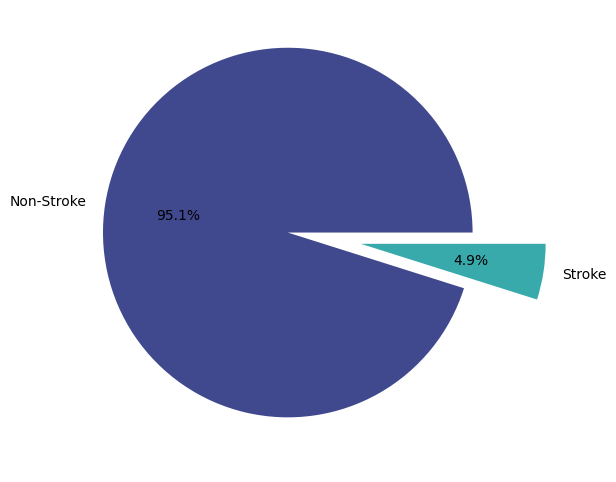

In [12]:
plt.figure(figsize=(10,6))
plt.pie(df.stroke.value_counts(),labels=['Non-Stroke','Stroke'],autopct='%1.1f%%',
        colors=sns.color_palette('mako',2),explode=(0.3,0.1)) # ,textprops={'fontsize':12,'style':'italic'}

### 1.2 Create a correlation table with the numeric values

<Axes: >

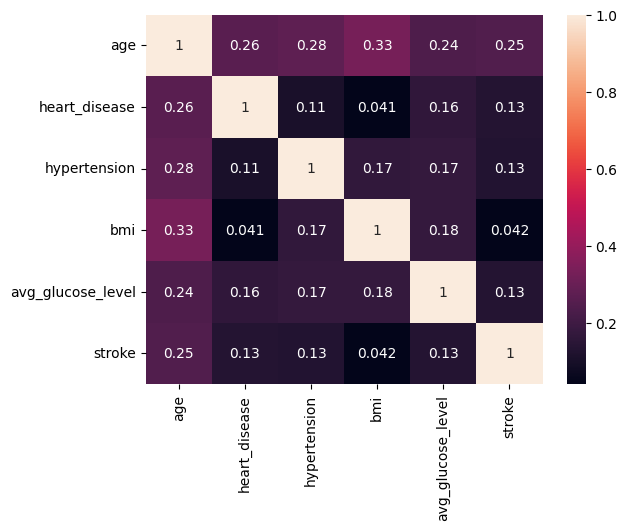

In [13]:
df_numeric = pd.concat([df["age"], df["heart_disease"], df["hypertension"], df["bmi"],df["avg_glucose_level"], df["stroke"], ], axis=1)
sns.heatmap(df_numeric.corr(), annot=True)

For having a stroke, we observe in decrease correlation in the following variables: 
1) **age** (0.25)
2) **heart_disease**, **glucose level** and **hypertension** all three with (0.13),
3) **bmi** (0.04)

## 1.3 Gender vs Stroke analysis

<Axes: xlabel='gender', ylabel='Density'>

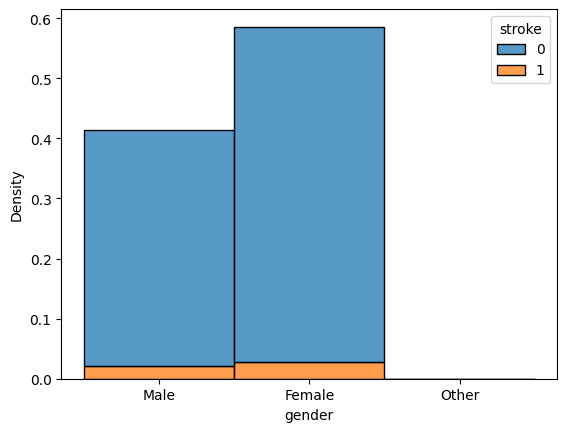

In [14]:
sns.histplot(data=df, x="gender", hue="stroke", multiple="stack", stat="density")


We observe more females having a stroke than males. Approximately 60% of the dataset are females and 40% are males.

But the amount of males in the data set is not the same as females.

We should calculate its proportion with respect to the samples

However, we can observe that the stroke probability is higher on males than females:

In [1151]:
df_gender_stroke = df.groupby(by=["gender"]).agg({"stroke":"sum","gender":"value_counts"})
df_gender_stroke["%_stroke"] = df_gender_stroke["stroke"] / df_gender_stroke["gender"] * 100
df_gender_stroke

,stroke,gender,%_stroke
gender,,,
Female,141,2994,4.709419
Male,108,2115,5.106383
Other,0,1,0.000000


<Axes: xlabel='gender', ylabel='age'>

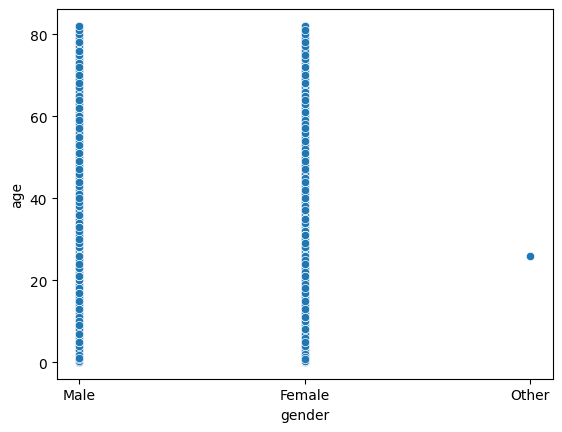

In [1152]:
sns.scatterplot(data=df, x="gender", y="age")

We see that we have a data set with all the spectrum of ages, for male and females. However for the gender "other" we have few individuals.

In [1153]:
df.loc[df.gender == "Other",:]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


There is only one individual not within the male/female genders. 

Since we do not have enough data for non-binary genders, **we are going to take it away from the dataset**. If we had 1000 or more we could have keep them, but in this case, it would bias the prediction, as it is an individual that did not suffer from a stroke.

When this individual is deleted, the prediction will only accept male and female genders.

## 1.5 Smoking status vs Stroke

<Axes: xlabel='smoking_status', ylabel='Density'>

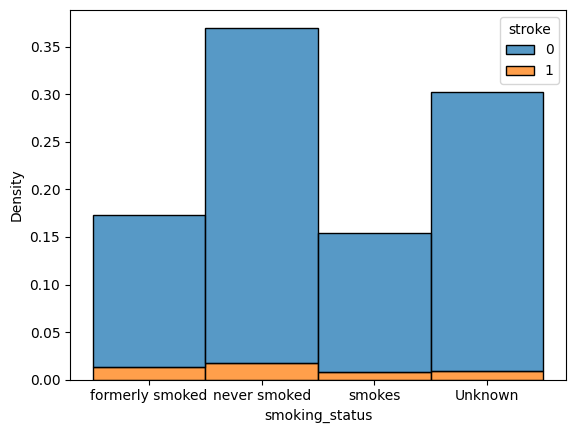

In [1154]:
sns.histplot(data=df, x="smoking_status", hue="stroke", multiple="stack", stat="density")

In [1155]:
df_smoked = df.copy()
def convert_smoked(smoking_status):
    if smoking_status == "formerly smoked":
        return "ever_smoked"
    elif smoking_status == "smokes":
        return "ever_smoked"
    else:
        return smoking_status
        
df_smoked.smoking_status = df_smoked.smoking_status.apply(convert_smoked)
df_smoked.smoking_status.unique()

array(['ever_smoked', 'never smoked', 'Unknown'], dtype=object)

In [1156]:
df_smoke_stroke = df_smoked.groupby(by=["smoking_status"]).agg({"stroke":"sum","smoking_status":"value_counts"})
df_smoke_stroke["%_stroke"] = df_smoke_stroke["stroke"] / df_smoke_stroke["smoking_status"] * 100
df_smoke_stroke

,stroke,smoking_status,%_stroke
smoking_status,,,
Unknown,47,1544,3.044041
ever_smoked,112,1674,6.690562
never smoked,90,1892,4.756871


                 stroke  smoking_status  %_stroke
smoking_status                                   
Unknown              47            1544  3.044041
formerly smoked      70             885  7.909605
never smoked         90            1892  4.756871
smokes               42             789  5.323194


<Axes: xlabel='smoking_status', ylabel='%_stroke'>

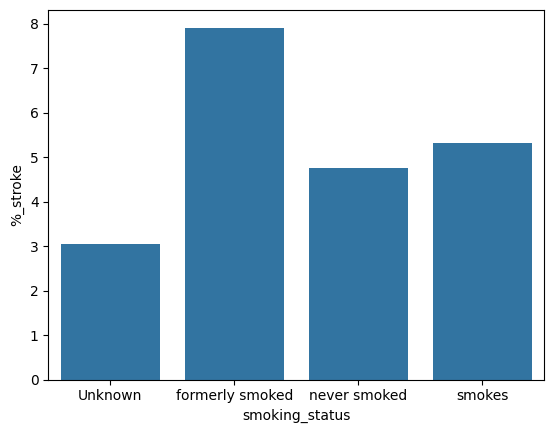

In [1157]:
df_smoke_stroke = df.groupby(by=["smoking_status"]).agg({"stroke":"sum","smoking_status":"value_counts"})
df_smoke_stroke["%_stroke"] = df_smoke_stroke["stroke"] / df_smoke_stroke["smoking_status"] * 100
print(df_smoke_stroke)
sns.barplot(x=df_smoke_stroke.index, y=df_smoke_stroke["%_stroke"])

According to the table, the fact of being a smoker it does not increase the chances of having a stroke. We can see that on the formerly smokers, the chances are high even if they have stopped smoking. 

However, if we merge the individuals that have ever smoked and the ones that have never smoked, the chances for "ever smokers" increases to 6.7% against 4.7% for the "never smokers".

Later on we will analyse this variable, but at first glance, we could say that smoking is not a cause for having a stroke, as the "actual smokers" have not a higher chance than the "formerly smokers".

## 1.6 Residence type vs Stroke

<Axes: xlabel='Residence_type', ylabel='Density'>

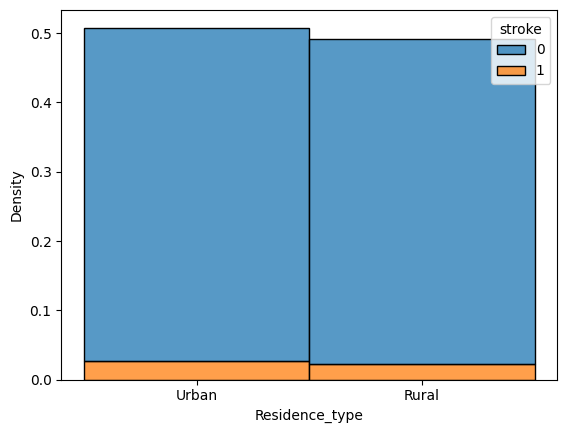

In [1158]:
sns.histplot(data=df, x="Residence_type", hue="stroke", multiple="stack", stat="density")

In [1159]:
df_r_type = df.groupby(by=["Residence_type"]).agg({"stroke":"sum","Residence_type":"value_counts"})
df_r_type["%_stroke"] = df_r_type["stroke"] / df_r_type["Residence_type"] * 100
print(df_r_type)

                stroke  Residence_type  %_stroke
Residence_type                                  
Rural              114            2514  4.534606
Urban              135            2596  5.200308


We observe that the *Urban* patients are more likely to have a stroke, with a 5.2% against a 4.5% for the patients living in *Rural* areas.

However, it looks like the residence type does not have a clear impact on the chances of having a stroke.

               stroke  work_type  %_work_type  %_stroke
work_type                                              
Govt_job           33        657        12.86      5.02
Never_worked        0         22         0.43      0.00
Private           149       2925        57.24      5.09
Self-employed      65        819        16.03      7.94
children            2        687        13.44      0.29


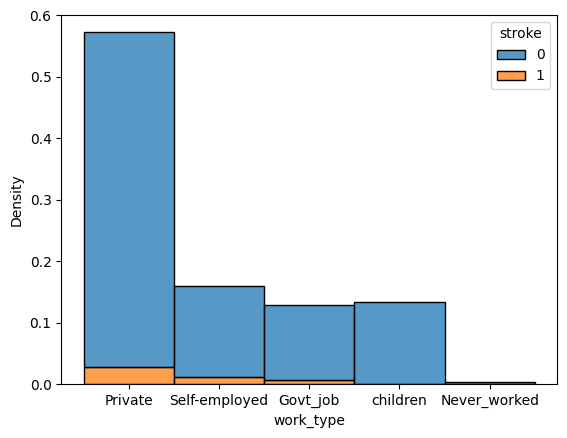

In [1160]:
total_wt = df.work_type.value_counts().sum()
sns.histplot(data=df, x="work_type", hue="stroke", multiple="stack", stat="density")
df_wt_group = df.groupby(by=["work_type"]).agg({"stroke":"sum","work_type":"value_counts"})
df_wt_group["%_work_type"] = round(df_wt_group["work_type"] / total_wt*100,2)
df_wt_group["%_stroke"] = round(df_wt_group["stroke"] / df_wt_group["work_type"]*100,2)
print(df_wt_group)

Patients of almost half (57%) of the data set work in private companies. The rest are self-employed (16%), goverment job (13%) or never worked (14%).

It looks like **having a self-employed job has the highest risk of stroke with 8%**, where as the **private or goverment jobs have the same rate (5%)**.

## 1.7 BMI vs Stroke analysis

<Axes: xlabel='bmi', ylabel='Density'>

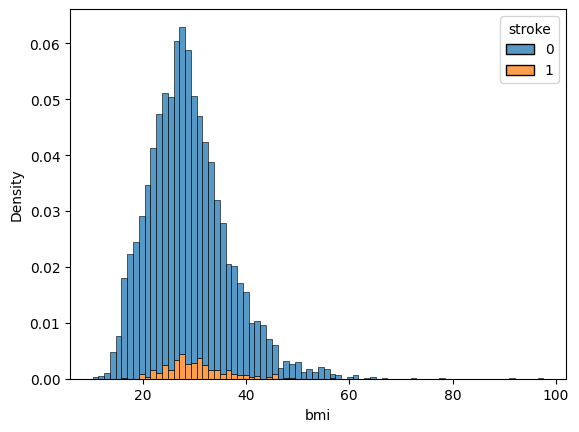

In [1161]:
sns.histplot(data=df, x="bmi", hue="stroke", multiple="stack", stat="density")

Looking at the figure we can say that when we are around a BMI of 30, it looks like the chances are higher.

The classification of BMI is as follows:

![BMI](images/BMI.jpg)

Let's study the BMI more in detail and divide the BMI into clusters according to the previous figure.

['Ext_Obese' 'NoBMI' 'Obese' 'Normal' 'Overweight' 'Underweight']


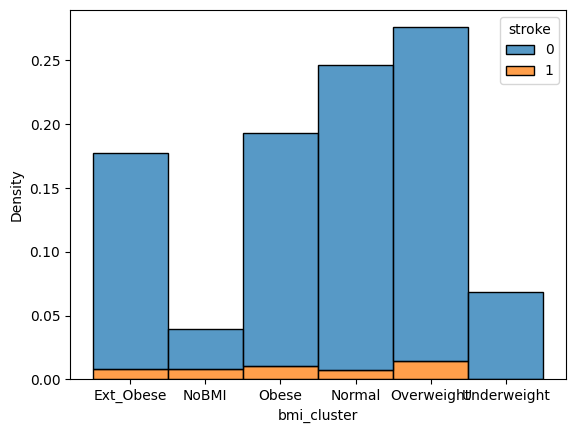

In [1162]:
# we are going to divide the BMI into clusters
def cluster_by_bmi(bmi):
    try:
        if bmi <= 18.5:
            return "Underweight"
        elif (bmi > 18.5) and (bmi <= 25):
            return "Normal"
        elif (bmi > 25) and (bmi <= 30):
            return "Overweight"
        elif (bmi > 30) and (bmi <= 35):
            return "Obese"
        elif (bmi > 35):
            return "Ext_Obese"
        else:
            return "NoBMI"
    except Exception as e:
        return "NoBMI"

df["bmi_cluster"] = df.bmi.apply(cluster_by_bmi)
sns.histplot(data=df, x="bmi_cluster", hue="stroke", multiple="stack", stat="density")
print(df.bmi_cluster.unique())

             stroke  bmi_cluster  %_stroke
bmi_cluster                               
Ext_Obese        42          908      4.63
NoBMI            40          201     19.90
Normal           37         1258      2.94
Obese            54          985      5.48
Overweight       75         1409      5.32
Underweight       1          349      0.29


<Axes: xlabel='bmi_cluster', ylabel='%_stroke'>

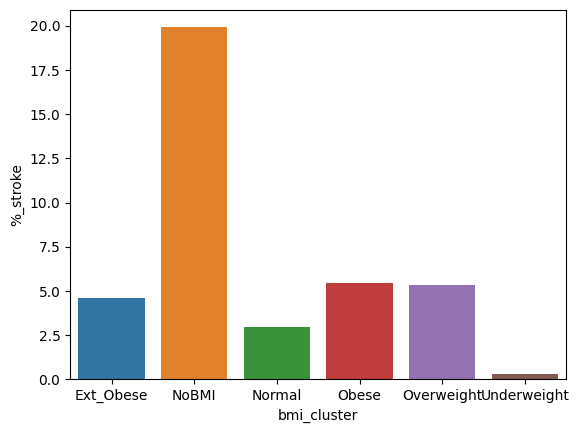

In [1163]:
# Calculating the percentage 
df_proc_bmi_group = df.groupby(by=["bmi_cluster"]).agg({"stroke":"sum","bmi_cluster":"value_counts"})
df_proc_bmi_group["%_stroke"] = round(df_proc_bmi_group["stroke"] / df_proc_bmi_group["bmi_cluster"]*100,2)
print(df_proc_bmi_group)
df_proc_bmi_group = df_proc_bmi_group.drop("bmi_cluster",axis=1)
sns.barplot(data=df_proc_bmi_group, x="bmi_cluster", y="%_stroke", hue="bmi_cluster")


Obese and Overweight BMIs have the same probability of having a stroke and they are also the higher.
We can observe that higher BMI values (Extremely Obese) does not increase the chances of having a stroke and we have enough individuals (around 1000) to conclude that. 

Since we have a high probability for the individuals (200 individuals) without BMI data, "NoBMI", taking a mean for the missing values does not seem a good idea.
In the data processing, if we take the BMI mean (around 28) to substitute the missing values, we will add a cluster with a high stroke probability (NoBMI with 20%) into the "Overweight" group, **generating a bias**.

Therefore, if we want to use the BMI as an explanatory variable, we should equally distribute the individuals between all the BMI. But even if we did this even distribution, the BMI would still not explain the probability of having a stroke.

**For the data treatment, we will probably erase this explanatory variable or drop the NA values (NoBMI).**

If we had an increase in strokes as we increase the BMI we could think about keeping the BMI variable.

## 1.8 Age vs Stroke

<Axes: xlabel='age', ylabel='stroke'>

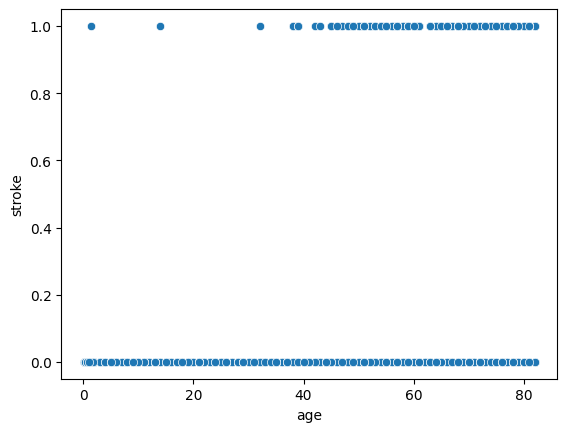

In [1164]:
sns.scatterplot(data=df, x="age", y="stroke")

We observe that the chances of having a stroke increases with ages over 40 years old

Let's study the age impact on having a stroke more in detail.

<Axes: xlabel='age_cluster', ylabel='Density'>

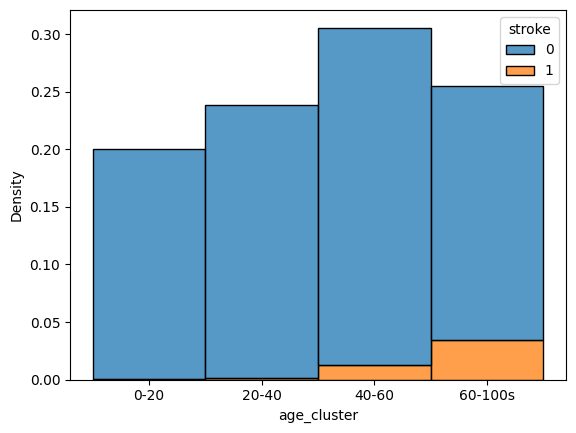

In [1165]:
def cluster_by_ages(age):
    if age <= 20:
        return "0-20"
    elif (age > 20) and (age <= 40):
        return "20-40"
    elif (age > 40) and (age <= 60):
        return "40-60"
    elif (age > 60):
        return "60-100s"
        
df["age_cluster"] = df.age.apply(cluster_by_ages)
df_age = df.sort_values("age_cluster")
sns.histplot(data=df_age, x="age_cluster", hue="stroke", multiple="stack", stat="density")

We observe that above 60 years old the chances increase by a lot

**We are going to split the older ages in 10 years span**

<Axes: xlabel='age_cluster', ylabel='Density'>

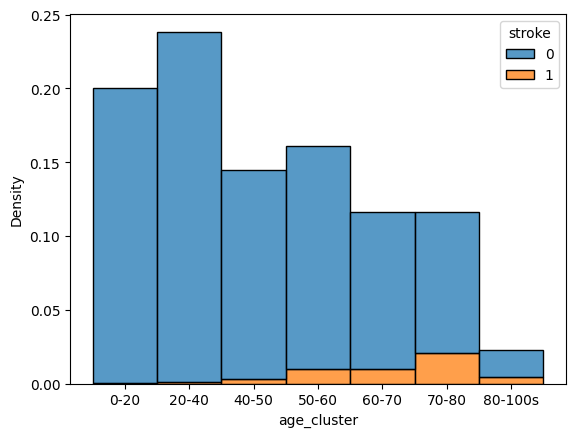

In [1166]:
def cluster_by_ages(age):
    if age <= 20:
        return "0-20"
    elif (age > 20) and (age <= 40):
        return "20-40"
    elif (age > 40) and (age <= 50):
        return "40-50"
    elif (age > 50) and (age <= 60):
        return "50-60"
    elif (age > 60) and (age <= 70):
        return "60-70"
    elif (age > 70) and (age <= 80):
        return "70-80"
    elif (age > 80):
        return "80-100s"
df["age_cluster"] = df.age.apply(cluster_by_ages)
df_age = df.sort_values("age_cluster")
sns.histplot(data=df_age, x="age_cluster", hue="stroke", multiple="stack", stat="density")

In [1167]:
# As we have different amount of individuals per age, we calculate the percentage of having a stroke over the number of individuals.
df_proc_age_group = df.groupby(by=["age_cluster"]).agg({"stroke":"sum","age_cluster":"value_counts"})
df_proc_age_group["%_stroke"] = round(df_proc_age_group["stroke"] / df_proc_age_group["age_cluster"]*100,2)
df_proc_age_group
#The chances of having a stroke clearly increases with age, being above 80 years old has a chance over 19 %


,stroke,age_cluster,%_stroke
age_cluster,,,
0-20,2,1025,0.20
20-40,6,1219,0.49
40-50,15,739,2.03
50-60,49,823,5.95
60-70,49,594,8.25
70-80,105,594,17.68
80-100s,23,116,19.83


In [1168]:
# Studying the same table by gender
df_proc_age_gender_group = df.groupby(by=["age_cluster","gender"], as_index=True).agg({"stroke":"sum","gender":"value_counts"})
df_proc_age_gender_group["%_stroke"] = round(df_proc_age_gender_group["stroke"] / df_proc_age_gender_group["gender"]*100,2)
print(df_proc_age_gender_group)


                    stroke  gender  %_stroke
age_cluster gender                          
0-20        Female       2     518      0.39
            Male         0     507      0.00
20-40       Female       6     801      0.75
            Male         0     417      0.00
            Other        0       1      0.00
40-50       Female       9     457      1.97
            Male         6     282      2.13
50-60       Female      25     457      5.47
            Male        24     366      6.56
60-70       Female      25     338      7.40
            Male        24     256      9.38
70-80       Female      62     352     17.61
            Male        43     242     17.77
80-100s     Female      12      71     16.90
            Male        11      45     24.44


Dropping counts for easier plotting
                    %_stroke
age_cluster gender          
0-20        Female      0.39
            Male        0.00
20-40       Female      0.75
            Male        0.00
            Other       0.00
40-50       Female      1.97
            Male        2.13
50-60       Female      5.47
            Male        6.56
60-70       Female      7.40
            Male        9.38
70-80       Female     17.61
            Male       17.77
80-100s     Female     16.90
            Male       24.44


<Axes: xlabel='age_cluster', ylabel='%_stroke'>

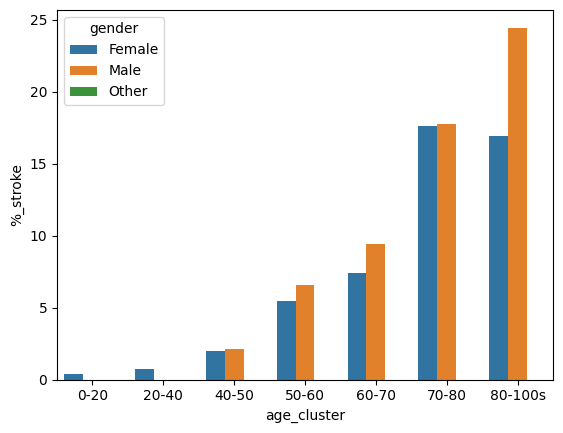

In [1169]:
print("Dropping counts for easier plotting")
df_age_gender_plot = df_proc_age_gender_group.copy()
df_age_gender_plot = df_age_gender_plot.drop("gender",axis=1)
df_age_gender_plot = df_age_gender_plot.drop("stroke",axis=1)
print(df_age_gender_plot)

sns.barplot(data=df_age_gender_plot, x="age_cluster", y="%_stroke", hue="gender")

The chances of having a stroke for people below 40 years old seems to be more highly for women, but still a very low probability < 1%.

The chances by gender above 40 years old are similar but slightly higher on men. We observe a high increase on men above 80 years old 24% vs 17% on women

With this data, we could not say that gender directly has an effect on the chances of having a stroke

## 1.9 Hypertension vs Stroke
We observe that the chances of having a stroke increase if the persons has **hypertension**

In [1170]:
df_hypert_group = df.groupby(by="hypertension").agg({"stroke":"sum", "hypertension":"value_counts"})
df_hypert_group["%_stroke"] = df_hypert_group["stroke"] / df_hypert_group["hypertension"] * 100 
print(df_hypert_group)

              stroke  hypertension   %_stroke
hypertension                                 
0                183          4612   3.967910
1                 66           498  13.253012


                          stroke  hypertension   %_stroke
age_cluster hypertension                                 
0-20        0                  2          1023   0.195503
            1                  0             2   0.000000
20-40       0                  5          1179   0.424088
            1                  1            40   2.500000
40-50       0                 13           686   1.895044
            1                  2            53   3.773585
50-60       0                 38           702   5.413105
            1                 11           121   9.090909
60-70       0                 36           485   7.422680
            1                 13           109  11.926606
70-80       0                 72           450  16.000000
            1                 33           144  22.916667
80-100s     0                 17            87  19.540230
            1                  6            29  20.689655


<Axes: xlabel='age_cluster', ylabel='%_stroke'>

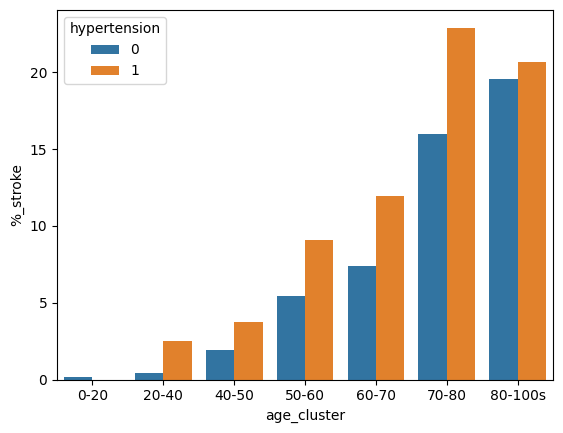

In [1171]:
df_hypert_age_group = df.groupby(by=["age_cluster","hypertension"]).agg({"stroke":"sum", "hypertension":"value_counts"})
df_hypert_age_group["%_stroke"] = df_hypert_age_group["stroke"] / df_hypert_age_group["hypertension"] * 100 
print(df_hypert_age_group)
df_hypert_age_group = df_hypert_age_group.drop(["stroke","hypertension"],axis=1)
sns.barplot(data=df_hypert_age_group, x="age_cluster", hue="hypertension", y="%_stroke")

We can clearly see that the hypertension patients have higher risks of stroke for any age group

## 1.10 Heart diseases vs Stroke

In general, we observe that the chances of having a stroke increase if the persons have a **heart disease**

In [1172]:
df_heart_group = df.groupby(by="heart_disease").agg({"stroke":"sum", "heart_disease":"value_counts"})
df_heart_group["%_stroke"] = df_heart_group["stroke"] / df_heart_group["heart_disease"] * 100 
print(df_heart_group)

               stroke  heart_disease   %_stroke
heart_disease                                  
0                 202           4834   4.178734
1                  47            276  17.028986


                           stroke  heart_disease   %_stroke
age_cluster heart_disease                                  
0-20        0                   2           1024   0.195312
            1                   0              1   0.000000
20-40       0                   6           1217   0.493016
            1                   0              2   0.000000
40-50       0                  15            723   2.074689
            1                   0             16   0.000000
50-60       0                  44            776   5.670103
            1                   5             47  10.638298
60-70       0                  33            526   6.273764
            1                  16             68  23.529412
70-80       0                  86            479  17.954071
            1                  19            115  16.521739
80-100s     0                  16             89  17.977528
            1                   7             27  25.925926


<Axes: xlabel='age_cluster', ylabel='%_stroke'>

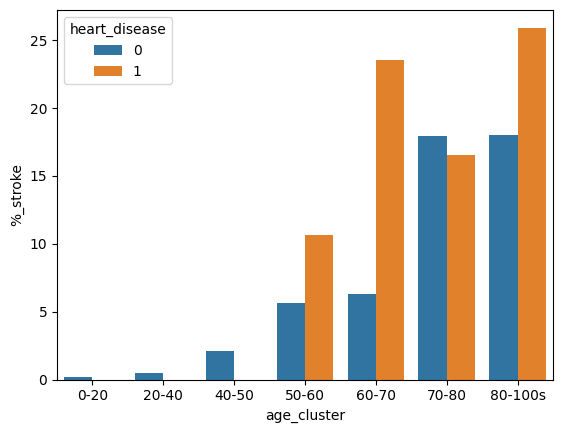

In [1173]:
df_heart_age_group = df.groupby(by=["age_cluster","heart_disease"]).agg({"stroke":"sum", "heart_disease":"value_counts"})
df_heart_age_group["%_stroke"] = df_heart_age_group["stroke"] / df_heart_age_group["heart_disease"] * 100 
print(df_heart_age_group)
df_heart_age_group = df_heart_age_group.drop(["stroke","heart_disease"],axis=1)
sns.barplot(data=df_heart_age_group, x="age_cluster", hue="heart_disease", y="%_stroke")

We can see that the patients with a heart disease have higher risks of stroke for most of the age groups

## 1.11 EverMarried vs Stroke

              stroke  ever_married  %_stroke
ever_married                                
No                29          1757  1.650541
Yes              220          3353  6.561288


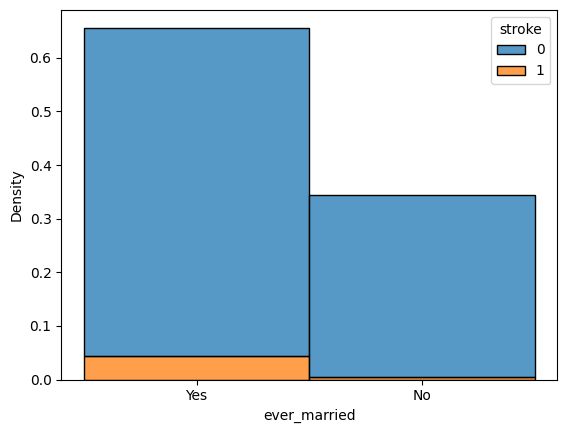

In [1174]:
sns.histplot(data=df, x="ever_married", hue="stroke", multiple="stack", stat="density")
df_married_group = df.groupby(by=["ever_married"]).agg({"stroke":"sum", "ever_married":"value_counts"})
df_married_group["%_stroke"] = df_married_group["stroke"] / df_married_group["ever_married"] * 100 
print(df_married_group)

At first sight, we observe that the married people could tend to have more strokes than the non-married.

This invites to think that being married could be a cause for a stroke, but we have seen that in the individuals we have youngsters and teenagers, and on these ages we have a low probability of having a stroke and being married too. 

Since being married is more related to age we are going to study the relantionship on both age and being married on suffering a stroke.

                          stroke  ever_married   %_stroke
age_cluster ever_married                                 
0-20        No                 2          1018   0.196464
            Yes                0             7   0.000000
20-40       No                 1           497   0.201207
            Yes                5           722   0.692521
40-50       No                 2            79   2.531646
            Yes               13           660   1.969697
50-60       No                 4            63   6.349206
            Yes               45           760   5.921053
60-70       No                 5            34  14.705882
            Yes               44           560   7.857143
70-80       No                13            50  26.000000
            Yes               92           544  16.911765
80-100s     No                 2            16  12.500000
            Yes               21           100  21.000000


<Axes: xlabel='age_cluster', ylabel='%_stroke'>

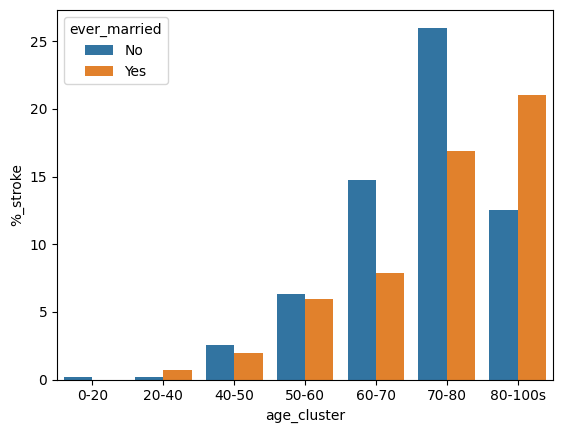

In [1175]:
df_married_group = df.groupby(by=["age_cluster","ever_married"]).agg({"stroke":"sum", "ever_married":"value_counts"})
df_married_group["%_stroke"] = df_married_group["stroke"] / df_married_group["ever_married"] * 100 
print(df_married_group)
df_married_group = df_married_group.drop(["stroke","ever_married"],axis=1)
sns.barplot(data=df_married_group, x="age_cluster", hue="ever_married", y="%_stroke")

On the previous barplot, we see that:
- Between 60 and 80 years old, the "never married" people has more chances of having a stroke.
- Above 80 years old, the chance increases for the "ever-married" ones.
- For people between 40 and 60 years old the chances are slightly the same.

At the beginning we saw that "ever-married" had 6% of the strokes against 1.65% of "never-married". 

However, looking at the barplot we could say that the people that have never been married have higher probabilities of having a stroke for ages between 60 and 80 years old. It decreases again for people above 80 years old. It seems that the fact of ever been married is not a direct cause.

Therefore, we can not conclude that being married could directly explain the chances of having a stroke. 

## 1.12 Glucose Level vs Stroke

At first sight, we can not see that a certain glucose level has an impact on the stroke chances.

<Axes: xlabel='avg_glucose_level', ylabel='stroke'>

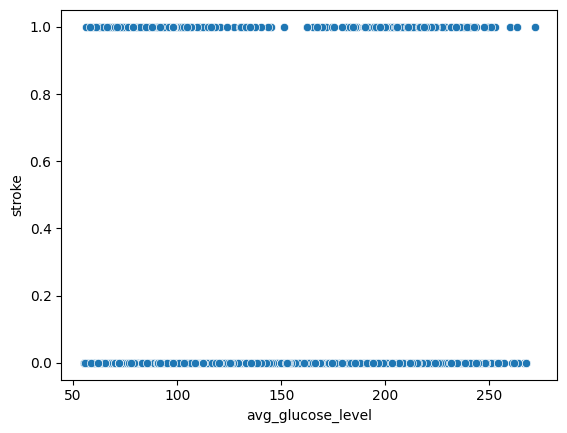

In [1176]:
sns.scatterplot(data=df, x="avg_glucose_level", y="stroke")

<Axes: xlabel='avg_glucose_level', ylabel='Density'>

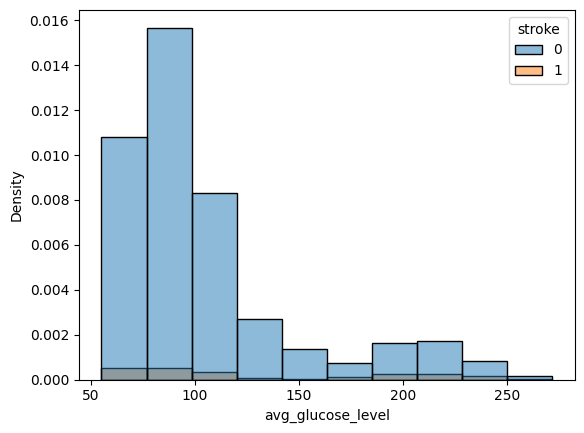

In [1177]:
sns.histplot(x=df["avg_glucose_level"], hue=df["stroke"], stat="density", bins=10)

We are going to classify the average glucose level according to the diabetes claissification (A1C% column):

![diabetes](images/diabetes_glucose_level.jpg)

['D04' 'D05' 'D06' 'D07' 'D08' 'D09' 'D10']


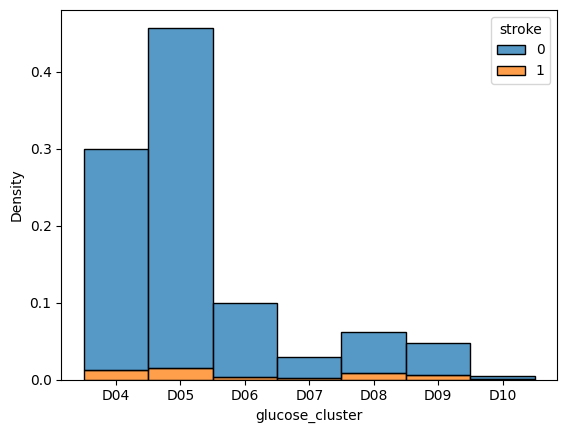

In [1178]:
def cluster_by_glucose(glucose):
    try:
        if glucose < 80:
            return "D04"
        elif glucose < 115:
            return "D05"
        elif glucose < 150:
            return "D06"
        elif glucose < 180:
            return "D07"
        elif glucose < 215:
            return "D08"
        elif glucose < 250:
            return "D09"
        elif glucose < 280:
            return "D10"
        elif glucose < 315:
            return "D11"
        elif glucose < 350:
            return "D12"
        elif glucose < 380:
            return "D13"
        else:
            return "D14"
    except Exception as e:
        return "Unknown"
        
df["glucose_cluster"] = df.avg_glucose_level.apply(cluster_by_glucose)
df = df.sort_values(by="glucose_cluster")
sns.histplot(data=df, x="glucose_cluster", hue="stroke", multiple="stack", stat="density")
print(df.glucose_cluster.unique())

In [1179]:
df_glucose_cluster = df.groupby(by="glucose_cluster", as_index=True).agg({"stroke":"sum", "glucose_cluster":"value_counts"})
df_glucose_cluster["%_stroke"] = df_glucose_cluster["stroke"]/df_glucose_cluster["glucose_cluster"] * 100
df_glucose_cluster

,stroke,glucose_cluster,%_stroke
glucose_cluster,,,
D04,63,1530,4.117647
D05,79,2338,3.378956
D06,17,511,3.326810
D07,11,148,7.432432
D08,42,314,13.375796
D09,32,244,13.114754
D10,5,25,20.000000


<Axes: xlabel='glucose_cluster', ylabel='%_stroke'>

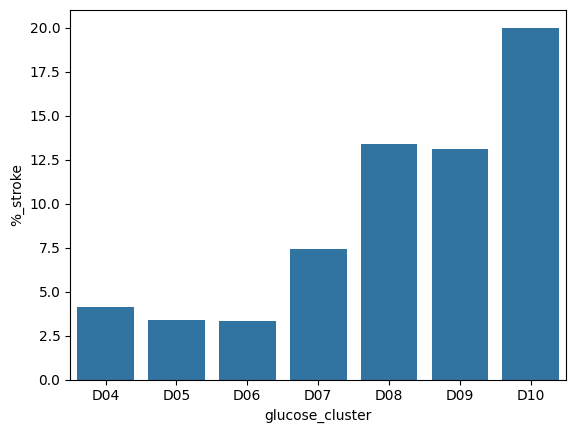

In [1180]:
sns.barplot(data=df_glucose_cluster, x=df_glucose_cluster.index, y="%_stroke")

We can see that for patients above the glucose group 7 in A1C%, which are clinically identified as diabetic, **the chances of having stroke increse for higher levels of diabetes**.


## 1.13 Worktype vs Stroke

<Axes: xlabel='work_type', ylabel='Density'>

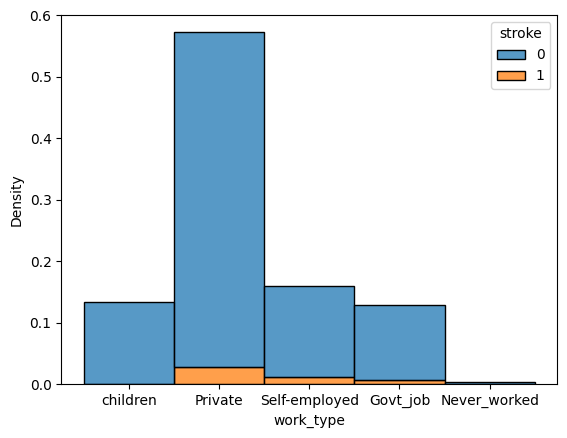

In [1181]:
sns.histplot(data=df, x="work_type", hue="stroke", multiple="stack", stat="density")

In [1182]:
df_work_type_group = df.groupby(by="work_type", as_index=True).agg({"stroke":"sum", "work_type":"value_counts"})
df_work_type_group["%_stroke"] = df_work_type_group["stroke"]/df_work_type_group["work_type"] * 100
df_work_type_group

,stroke,work_type,%_stroke
work_type,,,
Govt_job,33,657,5.022831
Never_worked,0,22,0.000000
Private,149,2925,5.094017
Self-employed,65,819,7.936508
children,2,687,0.291121


We observe a 5% of strokes on the private and goverment jobs. The self-employed jobs have an 8% chance of having a stroke. 

Thus, it looks like **self-employed workers have a higher chance of suffering a stroke**. This could be related to a more stressfull job type.

# 2. Data pre-processing (cleaning and transforming)

Before starting with the variable selection, we must transform our data set. In order to prepare it for the modelling, we are going to:
1) Drop the **id** number, **ever_married** and **smoking_status** as we haven't found a direct correlation.
2) Drop the NA values of the **bmi** column. On the *Data Analysis* part, we saw that if we took the mean of the BMI to substitute the NA values, we will probably bias the data by creating 40 new strokes with BMI=28, which is not true. Also, we had seen that the BMI does not have a high correlation on strokes. For these reasons we are going to drop only the NA values and keep the rest to see if the feature is important during the *Feature Selection*.
3) Erase the only individual having **Other as gender**, as we do not have enough data for this non-binary gender.
4) For the non-numerical variables *(gender, 	ever_married, 	work_type, 	Residence_type, 	smoking_status)* we are going to use **one-hot-encoding**. As the status are defined as we we can assume that we can have one work type, being married once, one gender, one residence type and one of the smoking status.
5) For the numerical variables (*age* and *avg_glucose_level*) we are going to **normalise** with a **StandardScaler** their values as it favours its learning potential.
6) Make a pipeline for treating the numerical and non-numerical variables
7) Make a data balancing by using **SMOTENC**. Note that SMOTENC permits to balance a data set with Categorical Features.

The dataset object after **data cleaning** is called *df_proc_**

The dataset object after **data transformation** is called *df_transf_**

In [254]:
df_proc = df_raw.copy()

## 2.1 Id and Smoking Status

Drop the id column and the Smoking Status.

As we have discussed in the data analysis part, the impact of the *smoking_status* is not logical, as it gives higher chances to the *formerly smokers* than the *smokers*. Therefore, we will not take this feature into account for our model.

In [255]:
df_proc = df_proc.drop(["id"], axis = 1)
df_proc = df_proc.drop(["smoking_status"], axis = 1)
df_proc = df_proc.drop(["ever_married"], axis = 1)
df_proc.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke'],
      dtype='object')

## 2.2 BMI treatment

Drop NA values on the BMI column

**NB:** For the sake of validating this dropping. We have tested to substitute the BMI NA values by its mean and we had obtained a worst model accuracy. Meaning that we insert a bias into the "Overweight" group, as discussed in the Data Analysis part.

In [256]:
# df_proc = df_proc.drop(["bmi"], axis = 1)
# df_proc["bmi"] = df_proc["bmi"].fillna(df_proc["bmi"].mean())
df_proc = df_proc.dropna() # as the NA values are only on the BMI column
df_proc.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'work_type',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke'],
      dtype='object')

## 2.3 Erase "Other" gender individual

In [257]:
idx = df_proc[df_proc.gender == "Other"].index
print(idx)
df_proc = df_proc.drop(index=idx, axis = 0)
df_proc.gender.unique()


Index([3116], dtype='int64')


array(['Male', 'Female'], dtype=object)

## 2.4 One hot encoding
On this part we start the *Data Transformation* to favour the learning.

We are going to call the transformed dataset as *df_transf*. We are going to:

1) There are also the columns *hypertension* and *heart_disease* that are already hot-encoded. We are going to transform them as boolean to ease pipeline automation.
2) Split the data set into train_test and testing before starting the *Data Transformation*

## 2.4.1 Convert int to bool
This will favor pipeline automation

In [258]:
# The data that is already hot econded in the dataset
df_proc.hypertension = df_proc.hypertension.astype(bool)
df_proc.heart_disease = df_proc.heart_disease.astype(bool)

## 2.4.2 Split the data set

Before starting the transformation, we are going to split the data into *training*, *validation* and *test*.

We are going to use:
1) the *training* set for *SMOTE* **after the transformation**
2) a *validation* set for *fine-tuning*
3) and *test* set for the final step

Notice that, we want to validate without any synthetic data in the *test* and *validation* set.

**We have focused the SMOTE on the training set because we have observed that if we smote all the data set, the results will tend to overfit the data.** 

When dividing the data set in three, we are going to use the following ratios:
- Training set: 70%
- Validation set: 15%
- Test set: 15%

In [259]:
from sklearn.model_selection import train_test_split


X = df_proc.drop(["stroke"], axis = 1) ## Remember that df_proc is the data after cleaning, not yet transformed
y = df_proc["stroke"]

# Define ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produce test split
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, stratify=y, test_size=ratio_test, random_state=0) # We stratify the target variable as we do not have a balance data set

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, stratify=y_remaining, test_size=ratio_val_adjusted, random_state=0)

In [260]:
# We check that the ratios of the test and validation sets are the same
print(y_train.value_counts())
print(y_test.value_counts())
print(y_val.value_counts())

stroke
0    3287
1     147
Name: count, dtype: int64
stroke
0    706
1     31
Name: count, dtype: int64
stroke
0    706
1     31
Name: count, dtype: int64


In [261]:
df_transf = df_proc.copy()  # A copy of the cleaned data set


In [195]:
# One hot encoding
# gender
df_transf.loc[:, ["gender"]] = pd.get_dummies(df_transf.gender,drop_first=True, prefix="gender").values # If True = Male, False = Female
df_transf.gender = df_transf.gender.astype(int) 
# # ever_married
# df_transf.loc[:, ["ever_married"]] = pd.get_dummies(df_transf.ever_married, drop_first=True).values.astype(int) # True = ever Married
# df_transf.ever_married = df_transf.ever_married.astype(int) 
# # Residence_type
df_transf.loc[:, ["Residence_type"]] = pd.get_dummies(df_transf.Residence_type, drop_first=True).values.astype(int) # True = Urban, False = Rural
df_transf.Residence_type = df_transf.Residence_type.astype(int) 
# # work_type
df_transf = pd.concat([df_transf, pd.get_dummies(df_transf.work_type, prefix="work_type").astype(int)],axis=1).drop(columns="work_type")
# #smoking_status
# df_transf = pd.concat([df_transf, pd.get_dummies(df_transf.smoking_status, prefix="smoke_status").astype(int)], axis=1).drop(columns="smoking_status")

In [196]:
# Harmonise the discrete data types into int32
df_transf.stroke = df_transf.stroke.astype(int) 
df_transf.hypertension = df_transf.hypertension.astype(int) 
df_transf.heart_disease = df_transf.heart_disease.astype(int) 

Now, all **discrete variables (True-False) are int32** and all **numeric variables are float64** .

In [197]:
df_transf.head()

,gender,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,228.69,36.6,1,0,0,1,0,0
2,1,80.0,0,1,0,105.92,32.5,1,0,0,1,0,0
3,0,49.0,0,0,1,171.23,34.4,1,0,0,1,0,0
4,0,79.0,1,0,0,174.12,24.0,1,0,0,0,1,0
5,1,81.0,0,0,1,186.21,29.0,1,0,0,1,0,0


## 2.5 Standardise the numerical values

As we are using a model to later do the feature selection, we are going to standardise the continuous variables: **age** and the **avg_glucose_level** to improve the model learning.

**REMEMBER:** we have to split the dataset **before doing the data transformation** as we are going to normalise according to the mean and the standard deviation: 

 $x_{norm} = (x - \bar{x})/\sigma$

In [198]:
df_transf_train = df_transf.copy()

In [199]:
df_transf_train.age = (X_train.age - X_train.age.mean())/X_train.age.std()
print(f"Age_mean: {df_transf_train.age.mean()}")
print(f"Age_std: {df_transf_train.age.std()}")

Age_mean: -2.027757370544258e-16
Age_std: 0.9999999999999999


In [200]:
df_transf_train.avg_glucose_level = (X_train.avg_glucose_level - X_train.avg_glucose_level.mean())/X_train.avg_glucose_level.std()
print(f"AGL_mean: {df_transf_train.avg_glucose_level.mean()}")
print(f"AGL_std: {df_transf_train.avg_glucose_level.std()}")


AGL_mean: 9.104216765708913e-17
AGL_std: 1.0


In [201]:
df_transf_train.bmi = (X_train.bmi - X_train.bmi.mean())/X_train.bmi.std()
print(f"BMI_mean: {df_transf_train.bmi.mean()}")
print(f"BMI_std: {df_transf_train.bmi.std()}")


BMI_mean: 8.897302748306438e-17
BMI_std: 1.0


In [202]:
df_transf_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4908 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   4908 non-null   int32  
 1   age                      3434 non-null   float64
 2   hypertension             4908 non-null   int32  
 3   heart_disease            4908 non-null   int32  
 4   Residence_type           4908 non-null   int32  
 5   avg_glucose_level        3434 non-null   float64
 6   bmi                      3434 non-null   float64
 7   stroke                   4908 non-null   int32  
 8   work_type_Govt_job       4908 non-null   int32  
 9   work_type_Never_worked   4908 non-null   int32  
 10  work_type_Private        4908 non-null   int32  
 11  work_type_Self-employed  4908 non-null   int32  
 12  work_type_children       4908 non-null   int32  
dtypes: float64(3), int32(10)
memory usage: 345.1 KB


## 2.6 Create a pipeline for treating the numerical and non-numerical variables

The transformations done in chapters 2.4 and 2.5 were done manually. In this section we are going to start automatisation by creating a pipeline with the dataset after the *Data Cleaning*. In our case, the *Data cleaning* has been done in chapters 2.1, 2.2 and 2.3.

As we have to do the transformation for both the training and the test sets, is better to create an automatic procedure in a *Pipeline* to apply the same transformation (by using a fucntion) to any new generated dataset. 

In [203]:
df_proc.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 4908 entries, 0 to 5109
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4908 non-null   object 
 1   age                4908 non-null   float64
 2   hypertension       4908 non-null   bool   
 3   heart_disease      4908 non-null   bool   
 4   work_type          4908 non-null   object 
 5   Residence_type     4908 non-null   object 
 6   avg_glucose_level  4908 non-null   float64
 7   bmi                4908 non-null   float64
 8   stroke             4908 non-null   int64  
dtypes: bool(2), float64(3), int64(1), object(3)
memory usage: 316.3+ KB


Remember that we have **bool** that are already transformed as *One-hot encoding* so we should take it out of the column selection.

We should apply:
- **One-hot encoding** to the *object* dtypes.
- **Standardisation** ONLY to the numerical types that are not *bool* (remember that we have bool types for *hypertension*, *bmi* and *heart_disease*).

In [204]:
from sklearn.compose import make_column_selector

# a function for getting the columns by dtype
def get_categorical_columns(df):
    """ categorical columns """
    categorical_columns_selector = make_column_selector(dtype_include= ['object'])
    categorical_columns = categorical_columns_selector(df)
    return categorical_columns


def get_numerical_columns(df):
    """ numerical columns. In our data set they are only of type float"""
    numerical_columns_selector = make_column_selector(dtype_exclude=['object','bool'])  # include only float (continous) variables
    numerical_columns = numerical_columns_selector(df)
    return numerical_columns


def get_binary_columns(df):
    """ columns that are already one hot encoded in the data set"""
    one_hot_columns_selector = make_column_selector(dtype_include= ['bool'])
    one_hot_columns = one_hot_columns_selector(df)
    return one_hot_columns
    

In [205]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [886]:
def transform_to_int(df):
    return df.astype(int)

def one_hot_and_std_transformation(df):
    """ A function that transforms a pre-cleaned data set by using:
        One Hot Encoding on the categorical variables
        Standardisation  on the numerical variables
        The already Hot econded variables are passed through with the remainder="passthrough" argument.
    """
    df = df.copy()
    
    numerical_columns = get_numerical_columns(df)
    nominal_columns = get_categorical_columns(df)
    
    numerical_pipeline = Pipeline([('scaler', StandardScaler())])
    nominal_pipeline = Pipeline([('hot_encoder', OneHotEncoder(drop="if_binary", dtype=np.int64, handle_unknown='ignore'))]) # , sparse_output=False
    
    preprocessor = ColumnTransformer([
        ('numerical_transformer', numerical_pipeline, numerical_columns),
        ('nominal_transformer', nominal_pipeline, nominal_columns),
    ], remainder="passthrough")
    
    preprocessor.fit(df)
    
    return preprocessor

def get_preprocessor_col_names(preprocessor):
    return [x.split("__")[1] for x in preprocessor.get_feature_names_out()]


def get_preprocessor_cat_names(preprocessor):
    cat_names = []
    for x in preprocessor.get_feature_names_out():
        if x.split("__")[0] == "nominal_transformer":
            cat_names.append(x.split("__")[1])
    return cat_names


In [887]:
preprocessor_train = one_hot_and_std_transformation(X_train)
preprocessor_test = one_hot_and_std_transformation(X_test)
preprocessor_val = one_hot_and_std_transformation(X_val)
preprocessor_train

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical_transformer',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'avg_glucose_level', 'bmi']),
                                ('nominal_transformer',
                                 Pipeline(steps=[('hot_encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype=<class 'numpy.int64'>,
                                                                handle_unknown='ignore'))]),
                                 ['gender', 'work_type', 'Residence_type'])])

In [888]:
X_train_preproc = preprocessor_train.transform(X_train)
X_test_preproc = preprocessor_test.transform(X_test)
X_val_preproc = preprocessor_test.transform(X_val)

We check that the obtained data is well transformed. Observe that now the dtypes are all float64

In [889]:
var_cols = get_preprocessor_col_names(preprocessor_train)
cat_names = get_preprocessor_cat_names(preprocessor_train)
df_transf_x_train = pd.DataFrame(X_train_preproc, columns=var_cols)
df_transf_x_test = pd.DataFrame(X_test_preproc, columns=var_cols)
df_transf_x_val = pd.DataFrame(X_val_preproc, columns=var_cols)
df_transf_x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      3434 non-null   float64
 1   avg_glucose_level        3434 non-null   float64
 2   bmi                      3434 non-null   float64
 3   gender_Male              3434 non-null   float64
 4   work_type_Govt_job       3434 non-null   float64
 5   work_type_Never_worked   3434 non-null   float64
 6   work_type_Private        3434 non-null   float64
 7   work_type_Self-employed  3434 non-null   float64
 8   work_type_children       3434 non-null   float64
 9   Residence_type_Urban     3434 non-null   float64
 10  hypertension             3434 non-null   float64
 11  heart_disease            3434 non-null   float64
dtypes: float64(12)
memory usage: 322.1 KB


In [890]:
df_transf_x_train.head(5)

,age,avg_glucose_level,bmi,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,hypertension,heart_disease
0,0.141063,-0.323311,-0.165491,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,-0.260807,0.149629,0.010803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.350112,-0.284012,-0.052159,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.364325,-0.266847,0.778941,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.796634,-0.103329,0.363391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## 2.7.0 Justification of using SMOTE
On the following code, we observe that for three different classifiers the accuracy is very high but it does not change even if we erase all features and we select only the *age* columns.

This leads to think that, as the data set is imbalanced, the training of any model will tend to overfit and give a high score but that is not true.

This invites to using SMOTE to balance the training data (next step)

In [913]:
lr_m = LogisticRegression()
lr_m.fit(df_transf_x_train, y_train)

print(f"LogisticRegression without SMOTE, SCORE: {lr_m.score(df_transf_x_test, y_test)}")

rfc_m = RandomForestClassifier(random_state=0)
rfc_m.fit(df_transf_x_train, y_train)

print(f"Random Forest Classifier without SMOTE, SCORE: {rfc_m.score(df_transf_x_test, y_test)}")

svc_m = SVC(C=0.1)
svc_m.fit(df_transf_x_train, y_train)

print(f"SVC without SMOTE, SCORE: {svc_m.score(df_transf_x_test, y_test)}")

# Taking only the AGE column, results are the same. Non-sense!
df_x_train_age_only = df_transf_x_train.loc[:, ["age"]]
df_x_test_age_only = df_transf_x_test.loc[:, ["age"]]

lr_m2 = LogisticRegression()
lr_m2.fit(df_x_train_age_only, y_train)

print("\nRESULTS with only the AGE column:")
print(f"LogisticRegression without SMOTE, and age only, SCORE: {lr_m2.score(df_x_test_age_only, y_test)}")

rfc_m2 = RandomForestClassifier(random_state=0)
rfc_m2.fit(df_x_train_age_only, y_train)

print(f"Random Forest Classifier without SMOTE,and age only, SCORE: {rfc_m2.score(df_x_test_age_only, y_test)}")

svc_m2 = SVC(C=0.1)
svc_m2.fit(df_x_train_age_only, y_train)

print(f"SVC without SMOTE,and age only, SCORE: {svc_m2.score(df_x_test_age_only, y_test)}")

LogisticRegression without SMOTE, SCORE: 0.9579375848032564
Random Forest Classifier without SMOTE, SCORE: 0.9538670284938942
SVC without SMOTE, SCORE: 0.9579375848032564

RESULTS with only the AGE column:
LogisticRegression without SMOTE, and age only, SCORE: 0.9579375848032564
Random Forest Classifier without SMOTE,and age only, SCORE: 0.9579375848032564
SVC without SMOTE,and age only, SCORE: 0.9579375848032564


## 2.7 Data balancing with SMOTENC

As we have observed, the dataset is imbalanced, in our case, there are more negative values of the target variable than positive values (strokes). 

Note that SMOTENC is specific for data sets with categorical features.

Balancing the data permits us to have a better model performance, also reduces overfitting as we had observed before using SMOTE. However, one of its disadvantages is that it focuses on the minority classes and thus ignores the majority class.

**NOTA:** We have decided to do SMOTE as we have observed that without SMOTE, the model gave us a high accuracy but without any change when tuning parameters or even choosing between several models. This had let me think that the lack of balance in the data tends to create overfitted models.

To avoid the overfitting and for the sake of having a tuning and more coherent model selection, we have used SMOTENC on the **training set** and isolated a **validation set** and a final **testing set** that we leave untoached until the end of our model testing.

In [312]:
from imblearn.over_sampling import SMOTENC

# Use SMOTENC with categorical features
smote = SMOTENC(categorical_features=[3, 4, 5, 6, 7, 8, 9, 10, 11], sampling_strategy="minority", random_state=0)
print(f"X_train before SMOTE {df_transf_x_train.shape}")
print(f"y_train before SMOTE {y_train.value_counts()}")
X_train_smote, y_train_smote = smote.fit_resample(df_transf_x_train, y_train)
print(f"X_train after SMOTE {X_train_smote.shape}")
print(f"y_train after SMOTE {y_train_smote.shape}")
y_train_smote.value_counts()

X_train before SMOTE (3434, 12)
y_train before SMOTE stroke
0    3287
1     147
Name: count, dtype: int64
X_train after SMOTE (6574, 12)
y_train after SMOTE (6574,)


stroke
0    3287
1    3287
Name: count, dtype: int64

# 3. Feature Selection
In this section we are going to do the feature selection without the need of training a model:
1) Correlation matrix
2) Mutual Information

When using feature selection with a given model, we need to do a pre-selection of models. 

We are going to compare the following **models** for *classification* during the **variable selection**:
- Logistic Regression and RandomForest with a Sequential Feature Selection using a forward step-wise approach. [SFS](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector) 
     
## 3.1 Linear correlation
To start, we are going to evaluate the stroke column on the correation matrix.


In [688]:
stroke_corr = df_transf.corr().loc[:, "stroke"].sort_values(ascending=False)
stroke_corr

stroke                     1.000000
age                        0.232313
hypertension               0.142503
avg_glucose_level          0.138984
heart_disease              0.137929
work_type_Self-employed    0.055338
bmi                        0.042341
work_type_Private          0.014972
gender                     0.006904
Residence_type             0.005988
work_type_Govt_job         0.003537
work_type_Never_worked    -0.014152
work_type_children        -0.080990
Name: stroke, dtype: float64

After the pre-processing we have the following correlations.

The higher positive correlated variables are:
1) **age** with 0.24
2) **heart_disease**, **avg_glucose_lvl** with 0.13
3) **hypertension** with 0.12
4) **ever_married** with 0.10
5) **WorkType__Self-employed** with 0.05

The higher negative related variables is **WorkType__children** with -0.08


## 3.2 Feature Selection with Mutual Info Classification

In [281]:
X_train_smote.columns

Index(['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban',
       'hypertension', 'heart_disease'],
      dtype='object')

<Axes: xlabel='MI scores', ylabel='None'>

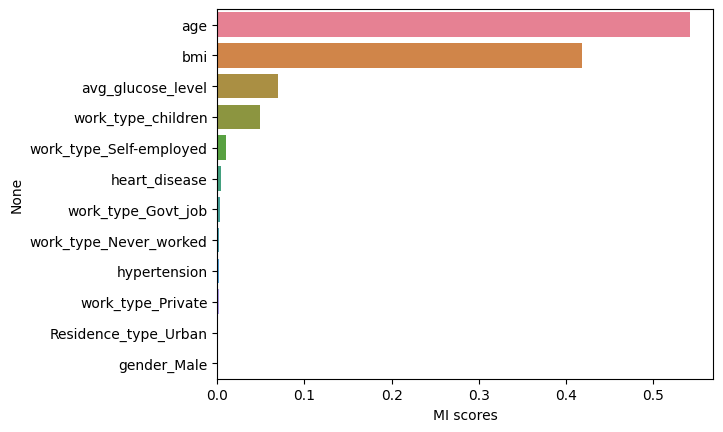

In [282]:
from sklearn.feature_selection import mutual_info_classif 

def get_MIC(X, y, discrete_features):
    X = X.copy()
    mi_scores = mutual_info_classif(X,y, discrete_features=discrete_features, random_state=0) 
    mi_scores = pd.Series(mi_scores, name="MI scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

# Obtain the discrete features in the preprocessor
discrete_names = get_preprocessor_cat_names(preprocessor_train)  # obtain from the preprocessor object the names of the categorical features
discrete_features = [X_train_smote.columns.get_loc(c) for c in discrete_names]

mic_scores = get_MIC(X_train_smote, y_train_smote, discrete_features)
sns.barplot(y=mic_scores.index, x=mic_scores, hue=mic_scores.index)

In [283]:
threshold = mic_scores.min() + mic_scores.std()  # Taking a 1-SE selection criteria
mic_scores[mic_scores > threshold]

age    0.541620
bmi    0.418507
Name: MI scores, dtype: float64

However with this method, we obtain a different list depending on the *random_state* seed. We have set it to 0 for reproducibility.

Also the mutual information does not give an idea of the performance of the selected variables. Moreover, if we want to automate it in a pipeline, we must find a method to select the features that does not depend on the random seed.


## 3.3 Feature Selection with Logistic Regression

<Axes: xlabel='coefficient', ylabel='None'>

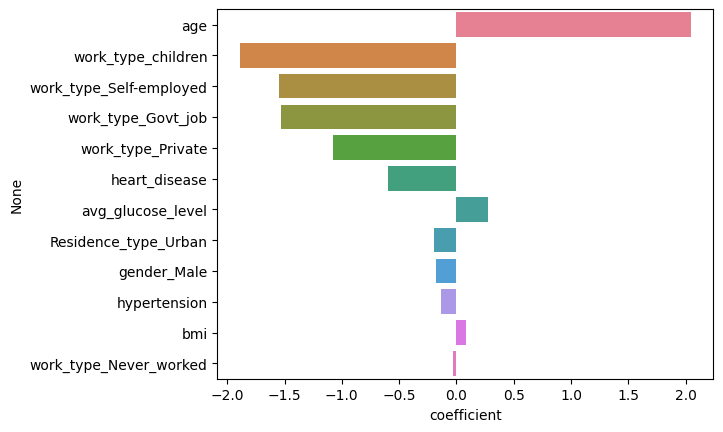

In [284]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(penalty="l1", solver='liblinear')
lr_model.fit(X_train_smote, y_train_smote)

coefs=pd.DataFrame({'coefficient':lr_model.coef_[0]}, index = X_train_smote.columns)

coefs.sort_values('coefficient', key=abs, ascending=False, inplace=True)

sns.barplot(y=coefs.index, x=coefs['coefficient'], hue=coefs.index)

With this method we can have an idea on the weight of each variable, however we can not generalize it into an automatic method, as the coefficients do not give an idea of the impact of using each variable inside the model, neither of the performance associated to this variable selection.

## 3.3 Feature Selection with Random Forest

By using Random Forest, in this part, we are going to check its **variable importance** with Mean Decrease Impurity (Gini Index)

In [285]:
from sklearn.ensemble import RandomForestClassifier

feature_names = X_train_smote.columns
rfc = RandomForestClassifier(random_state=0) 

rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=0)

In [286]:
importances = rfc.feature_importances_
rfc_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
rfc_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)  # Standard deviation of each feature on all the calculated trees
rfc_importances

age                        0.461441
avg_glucose_level          0.209802
bmi                        0.185921
hypertension               0.025462
gender_Male                0.020910
Residence_type_Urban       0.020592
work_type_children         0.020093
work_type_Self-employed    0.017251
work_type_Private          0.014523
heart_disease              0.013101
work_type_Govt_job         0.010581
work_type_Never_worked     0.000324
dtype: float64

Text(0, 0.5, 'Mean decrease in impurity')

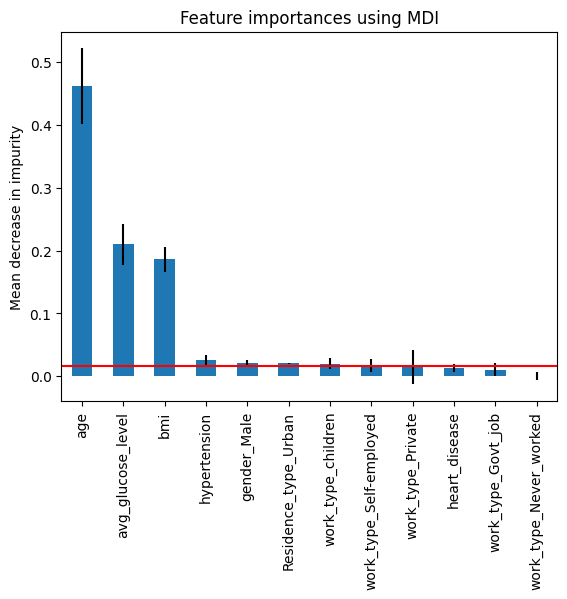

In [287]:
fig, ax = plt.subplots()
rfc_importances.plot.bar(yerr=rfc_std, ax=ax)
threshold = rfc_importances.min() + rfc_std.mean()
ax.axhline(y = threshold, color = 'r', linestyle = '-') 
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

array([ True,  True,  True,  True, False, False, False,  True,  True,
        True,  True, False])

In [288]:
threshold = rfc_importances.min() + rfc_std.mean()
rfc_imp_filtered = rfc_importances[rfc_importances > threshold]
print(rfc_imp_filtered)
rfc_importances_sel = rfc_imp_filtered.index.to_list()
print(rfc_importances_sel)

age                        0.461441
avg_glucose_level          0.209802
bmi                        0.185921
hypertension               0.025462
gender_Male                0.020910
Residence_type_Urban       0.020592
work_type_children         0.020093
work_type_Self-employed    0.017251
dtype: float64
['age', 'avg_glucose_level', 'bmi', 'hypertension', 'gender_Male', 'Residence_type_Urban', 'work_type_children', 'work_type_Self-employed']


We have set a threshold to select the variables above 1 standard deviation from the minimum value:

$threshold = x_{min} + x_{std}$

The variable importance using Random Forest returns:
1) That the **age**, **bmi** and **average glucose level** are the most important variables.
2) **Gender_male**, **work_type_children**, **work_type_Self-employed**, **hypertension** and **Residence_type_Urban** are also important but on a second level.

## 3.5 Variable selection with SFS and Cross-validation

SFS with Cross-validation will select the best scored features accross the Kfolds.

**NOTA: If we do not use SMOTE.** It is very important to note that we have an imbalanced data set for our target variable *stroke* (more negatives than positives). Therefore, if SMOTE is not used, we must use a **stratified K-fold for compensating this imbalance when dividing the train and test set during Cross-Validation**.


In [289]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline

## 3.5.1 SFS with Logistic Regression

In [314]:
# We check that stratified 3-fold is balanced

cv_strat = StratifiedKFold(n_splits=3)  # We take 3 folds, as it normally gives good results
for train, test in cv_strat.split(X_train_smote, y_train_smote):
    print('train -  {}   |   test -  {}'.format(
    np.bincount(y_train_smote.iloc[train]), np.bincount(y_train_smote.iloc[test])))

# For each fold (train and test) we have the same amount of strokes

train -  [2191 2191]   |   test -  [1096 1096]
train -  [2191 2192]   |   test -  [1096 1095]
train -  [2192 2191]   |   test -  [1095 1096]


Use a forward step strategy on the **Logistic Regression** model

In [291]:
sfs_lr = SequentialFeatureSelector(estimator=lr_model,
                                   direction="forward",
                                   tol=1e-5,
                                   cv=cv_strat,
                                   scoring="accuracy")
sfs_lr.fit(X_train_smote, y_train_smote)
print(sfs_lr.get_feature_names_out())
lr_model.fit(X_train_smote, y_train_smote)
print(lr_model.score(df_transf_x_val, y_val))

['age' 'avg_glucose_level' 'gender_Male' 'work_type_children']
0.7530529172320217


For the logistic regression, when we select 4 variable we obtain the best mean accuracy. 

These variables are **age, work_type_children, avg_glucose_level** and **gender_Male** 


## 3.5.2 SFS with Random Forest Classifier

We use a forward step strategy on the **RandomForest** model

In [43]:
rfc_model = RandomForestClassifier(max_depth=5, random_state=0) # max_depth = 5 permits to avoid overfitting 
feature_names = df_transf_x_train.columns
train_scores = np.array([])
val_scores = np.array([])
features_sel = []
for n_features_to_select in range(1, len(feature_names)):
    sfs_rfc = SequentialFeatureSelector(estimator=rfc_model,
                                    direction="forward",
                                    n_features_to_select=n_features_to_select,
                                    cv=cv_strat,
                                    scoring="accuracy")
    rfc_sel = make_pipeline(sfs_rfc, rfc_model)
    rfc_sel.fit(X_train_smote, y_train_smote)
    print(f"n_features_to_select: {n_features_to_select}")
    print(f"Features selected: {feature_names[sfs_rfc.get_support()]}")
    print(f"Accuracy in TRAININING data set: {rfc_sel.score(X_train_smote, y_train_smote)}")
    print(f"Accuracy in VALIDATION data set: {rfc_sel.score(df_transf_x_val, y_val)}")
    features_sel.append(feature_names[sfs_rfc.get_support()])
    train_scores = np.append(train_scores, rfc_sel.score(X_train_smote, y_train_smote))
    val_scores = np.append(val_scores, rfc_sel.score(df_transf_x_val, y_val))
    

n_features_to_select: 1
Features selected: Index(['age'], dtype='object')
Accuracy in TRAININING data set: 0.813964101003955
Accuracy in VALIDATION data set: 0.6933514246947082
n_features_to_select: 2
Features selected: Index(['age', 'avg_glucose_level'], dtype='object')
Accuracy in TRAININING data set: 0.8313051414663827
Accuracy in VALIDATION data set: 0.7435549525101763
n_features_to_select: 3
Features selected: Index(['age', 'avg_glucose_level', 'gender_Male'], dtype='object')
Accuracy in TRAININING data set: 0.8303924551262549
Accuracy in VALIDATION data set: 0.7530529172320217
n_features_to_select: 4
Features selected: Index(['age', 'avg_glucose_level', 'gender_Male', 'work_type_Govt_job'], dtype='object')
Accuracy in TRAININING data set: 0.8369333738971707
Accuracy in VALIDATION data set: 0.7815468113975577
n_features_to_select: 5
Features selected: Index(['age', 'avg_glucose_level', 'bmi', 'gender_Male', 'work_type_Govt_job'], dtype='object')
Accuracy in TRAININING data set: 0.

In [54]:
idx = np.argmax(train_scores)  # Select the first max score. As the order is ascending, we select the less amount of features
feats_sfs_rfc = features_sel[idx]
feats_sfs_rfc

Index(['age', 'avg_glucose_level', 'gender_Male', 'work_type_Govt_job'], dtype='object')

Using a forward step strategy for both **LogistcRegression** and **RandomForest**, the results differ only on *work_type_Govt_job*. Also remember that we have used a parameter *max_depth=5* in *RandomForest* to avoid overfitting, by changing this parameter the variables selected will differ.


## 3.5.3 Choose between several feature selection strategies

Here under we are going to compare three feature selection strategies on several models:

1) Forward step (SFS) using a linear regression model (*df_x_train_sel_sfs*)
2) Variable importance with RandomForest with a 1-SE criteria (*df_x_train_sel_rf_importance*)
3) A manual selection (*df_x_train_sel_manual*). This manual selection was done according to the linear correlation and the analytical study.



**NB:** Using only one validating set with a training set (pre-defined)
[source](https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn)

In [292]:
# SFS on linear regression
print(sfs_lr.get_feature_names_out())
df_x_train_sel_sfs = X_train_smote[sfs_lr.get_feature_names_out()]
df_x_val_sel_sfs = df_transf_x_val[sfs_lr.get_feature_names_out()]

['age' 'avg_glucose_level' 'gender_Male' 'work_type_children']


In [293]:
# Using variable importance on Random Forest with a 1-SE criteria
print(rfc_importances_sel)
df_x_train_sel_rf_importance = X_train_smote[rfc_importances_sel] 
df_x_val_sel_rf_importance = df_transf_x_val[rfc_importances_sel]
df_x_test_sel_rf_importance = df_transf_x_test[rfc_importances_sel]

['age', 'avg_glucose_level', 'bmi', 'hypertension', 'gender_Male', 'Residence_type_Urban', 'work_type_children', 'work_type_Self-employed']


In [294]:
# Manual selection
feature_selection = ["age","heart_disease","bmi","hypertension", "avg_glucose_level", "work_type_Self-employed"]
df_x_train_sel_manual = X_train_smote[feature_selection] 
df_x_val_sel_manual = df_transf_x_val[feature_selection]
df_x_test_sel_manual = df_transf_x_test[feature_selection]
df_x_train_sel_manual.columns 

Index(['age', 'heart_disease', 'bmi', 'hypertension', 'avg_glucose_level',
       'work_type_Self-employed'],
      dtype='object')

### 3.5.3.1 Comparing the three feature selection strategies
In this part we are going to use the **training set** with all three variable selection strategies.

For the tuning, instead of doing K-fold cross-validation, the idea is to create a single Cross-Validation set made up of our **Validation set**. By this way, we are going to tune our parameters with respect to a controlled and isolated set, i.e. our **Validation set**.
We can do this by creating this cross-validation set by giving -1 indexes to the lines corresponding to the **training set** and 0 index for the lines correspending to the **Validation set**. Then the split is done in the *PredefinedSplit* function.

In [300]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV

def create_tuning_split(X_train, X_val, y_train, y_val):
    """ A tuning split created with train and val sets
    @return:
        X_tuning: X set for tuning
        y_tuning: y set for tuning
        cv_tuning: is the split used with GridSearchCV, it contains -1 (train set) or 0 (val set) as indexes  
    """
    X_tuning = np.concatenate((X_train, X_val), axis=0)
    y_tuning = np.concatenate((y_train, y_val), axis=0)
    split_index = [-1]*len(X_train) + [0]*len(X_val)
    cv_tuning = PredefinedSplit(test_fold=split_index)
    return X_tuning, y_tuning, cv_tuning

In [301]:
# Create the filtered train and validation sets according to variable selection 
X_tuning_sfs, y_tuning_sfs, cv_tuning_sfs = create_tuning_split(df_x_train_sel_sfs, df_x_val_sel_sfs, y_train_smote, y_val)
X_tuning_rf_imp, y_tuning_rf_imp, cv_tuning_rf_imp = create_tuning_split(df_x_train_sel_rf_importance, df_x_val_sel_rf_importance, y_train_smote, y_val)
X_tuning_manual, y_tuning_manual, cv_tuning_manual = create_tuning_split(df_x_train_sel_manual, df_x_val_sel_manual, y_train_smote, y_val)

feature_sel_modes = ["Forward strategy on LR model",
                    "RandomForest Importance + 1SE",
                    "Manual feature selection"]

xy_tuning_sets = [(X_tuning_sfs, y_tuning_sfs),  # Forward strategy
                  (X_tuning_rf_imp, y_tuning_rf_imp),  # RandomForest Importance + 1SE
                  (X_tuning_manual, y_tuning_manual)]  # Manual feature selection

cv_tuning_splits = [cv_tuning_sfs,
                   cv_tuning_rf_imp,
                   cv_tuning_manual]

In [302]:
def gs_find_best_feature_strategy(feature_sel_modes, xy_tuning_sets, cv_tuning_splits, pipe, hyper_param):
    """ A function to compare all the feature selection modes in xy_tuning_sets"""
    params = []
    scores = []

    print(f"Hyper Parameters: {hyper_param}")
    for i in range(0, len(feature_sel_modes)):
        gs = GridSearchCV(estimator=pipe,
                          param_grid=hyper_param,
                          cv = cv_tuning_splits[i],
                          scoring="accuracy" 
                         )
        
        X_tuning = xy_tuning_sets[i][0]
        y_tuning = xy_tuning_sets[i][1]
        gs.fit(X_tuning, y_tuning)
    
        print(f"\n**** BEST TUNING with {feature_sel_mode[i]} as VARIABLE SELECTION ****")
        print(gs.best_params_)
        params.append(gs.best_params_)
        print(gs.best_score_)
        scores.append(gs.best_score_)
    
    return params, scores

In [303]:
# Generic classification model pipeline 
pipe = Pipeline(
    [
        ("clf", "passthrough") # Classifier model
    ]
)

# 4.Model selection, tuning and evaluation
Once we have done the best feature selection, now, we are going to compare the following **models** for *classification*:
1) Logistic Regression
2) RandomForest
3) SVC
4) MLPclassifier

At the same of selecting the model, we are going to select the best feature strategy:
1) Select a model
2) Train the model against the validation set
3) Select the best scored strategy in validation set between the proposed feature selection strategies.

For the **parameter tuning** we are going to use **GridSearchCV**. For the purpose of *tuning the models*, we are going to use a **pre-defined Split** that it is the union of:
1) The SMOTE data as a training set. This set is used for training the models.
2) The Validation Set that we had separated previously. We are going to tune the parameters and select the ones associated to the best score on this set.

Finally, we are going to evaluate the results with respect to our testing data set.

## 4.1 Best feature selections

We observe that **Random Forest Importance + 1SE** is the best feature selection for:
1) Random Forest
2) MLP Classifier

We observe that **Manual feature selection** (*age, heart_disease, bmi, hypertension, avg_glucose_level, work_type_Self-employed*) is the best feature selection for:
1) Logistic Regression
2) SVC

In [307]:
n_estimators = [5, 10, 30, 50, 100]
min_samples_leaf = [1, 2, 3, 4, 5, 10, 15]
max_depths = [3, 5, 7, 10, 12, 15, 20, 30, 40]

hyper_param_rf = [
        {   "clf": [RandomForestClassifier(random_state=0)], 
        "clf__n_estimators": n_estimators, 
        "clf__min_samples_leaf": min_samples_leaf,
        "clf__max_depth": max_depths
    }]

params_rf, scores_rf = gs_find_best_feature_strategy(feature_sel_modes, xy_tuning_sets, cv_tuning_splits, pipe, hyper_param_rf)

Hyper Parameters: [{'clf': [RandomForestClassifier(random_state=0)], 'clf__n_estimators': [5, 10, 30, 50, 100], 'clf__min_samples_leaf': [1, 2, 3, 4, 5, 10, 15], 'clf__max_depth': [3, 5, 7, 10, 12, 15, 20, 30, 40]}]

**** BEST TUNING with Forward strategy with LR as VARIABLE SELECTION ****
{'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 50}
0.7774762550881954

**** BEST TUNING with RandomForest Importance + 1SE as VARIABLE SELECTION ****
{'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 30, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 50}
0.8466757123473542

**** BEST TUNING with Manual feature selection as VARIABLE SELECTION ****
{'clf': RandomForestClassifier(random_state=0), 'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 10}
0.8439620081411127


In [308]:
hyper_param_mlp = [
    {   "clf": [MLPClassifier(random_state=0)],
        "clf__tol": [1e-2, 1e-3, 1e-4],
        "clf__max_iter": [5000, 7000, 10000],
        "clf__solver": ["lbfgs", "sgd", "adam"],
        "clf__learning_rate": ["constant", "invscaling", "adaptive"],
    }
] 

params_mlp, scores_mlp = gs_find_best_feature_strategy(feature_sel_modes, xy_tuning_sets, cv_tuning_splits, pipe, hyper_param_mlp)

Hyper Parameters: [{'clf': [MLPClassifier(random_state=0)], 'clf__tol': [0.01, 0.001, 0.0001], 'clf__max_iter': [5000, 7000, 10000], 'clf__solver': ['lbfgs', 'sgd', 'adam'], 'clf__learning_rate': ['constant', 'invscaling', 'adaptive']}]


C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning:


**** BEST TUNING with Forward strategy with LR as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'invscaling', 'clf__max_iter': 5000, 'clf__solver': 'sgd', 'clf__tol': 0.01}
0.7978290366350068


C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning:


**** BEST TUNING with RandomForest Importance + 1SE as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'constant', 'clf__max_iter': 10000, 'clf__solver': 'lbfgs', 'clf__tol': 0.001}
0.8507462686567164


C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning:


**** BEST TUNING with Manual feature selection as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'constant', 'clf__max_iter': 10000, 'clf__solver': 'lbfgs', 'clf__tol': 0.0001}
0.8371777476255088


Hyper Parameters: [{'clf': [MLPClassifier(random_state=0)], 'clf__tol': [0.01, 0.001, 0.0001], 'clf__max_iter': [5000, 7000, 10000], 'clf__solver': ['lbfgs', 'sgd', 'adam'], 'clf__learning_rate': ['constant', 'invscaling', 'adaptive']}]

**** BEST TUNING with Forward strategy with LR as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'invscaling', 'clf__max_iter': 5000, 'clf__solver': 'sgd', 'clf__tol': 0.01}
0.7978290366350068

**** BEST TUNING with RandomForest Importance + 1SE as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'constant', 'clf__max_iter': 10000, 'clf__solver': 'lbfgs', 'clf__tol': 0.001}
0.8507462686567164

**** BEST TUNING with Manual feature selection as VARIABLE SELECTION ****
{'clf': MLPClassifier(random_state=0), 'clf__learning_rate': 'constant', 'clf__max_iter': 10000, 'clf__solver': 'lbfgs', 'clf__tol': 0.0001}
0.8371777476255088

In [309]:
c_values_lr = [0.01, 0.1, 0.2, 0.5, 1]

hyper_param_lr = [
    {   "clf": [LogisticRegression()],
        "clf__solver": ["lbfgs" , "saga"], #liblinear", "newton-cg", "newton-cholesky","saga"
        "clf__C": c_values_lr,
        "clf__multi_class":  ["ovr", "multinomial"]
    }]

params_lr, scores_lr = gs_find_best_feature_strategy(feature_sel_modes, xy_tuning_sets, cv_tuning_splits, pipe, hyper_param_lr)

Hyper Parameters: [{'clf': [LogisticRegression()], 'clf__solver': ['lbfgs', 'saga'], 'clf__C': [0.01, 0.1, 0.2, 0.5, 1], 'clf__multi_class': ['ovr', 'multinomial']}]

**** BEST TUNING with Forward strategy with LR as VARIABLE SELECTION ****
{'clf': LogisticRegression(), 'clf__C': 0.1, 'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs'}
0.7503392130257802

**** BEST TUNING with RandomForest Importance + 1SE as VARIABLE SELECTION ****
{'clf': LogisticRegression(), 'clf__C': 0.1, 'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs'}
0.7503392130257802

**** BEST TUNING with Manual feature selection as VARIABLE SELECTION ****
{'clf': LogisticRegression(), 'clf__C': 0.1, 'clf__multi_class': 'ovr', 'clf__solver': 'lbfgs'}
0.751696065128901


In [310]:
c_values_svc = [0.01, 0.1, 0.5, 1, 5, 10, 20]

hyper_param_svc = [
    {   "clf": [SVC()],
        "clf__C": c_values_svc,
        "clf__kernel": ["linear", "rbf", "poly", "sigmoid"],
        "clf__decision_function_shape": ["ovo","ovr"]
    }
] 

params_svc, scores_svc = gs_find_best_feature_strategy(feature_sel_modes, xy_tuning_sets, cv_tuning_splits, pipe, hyper_param_svc)

Hyper Parameters: [{'clf': [SVC()], 'clf__C': [0.01, 0.1, 0.5, 1, 5, 10, 20], 'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'clf__decision_function_shape': ['ovo', 'ovr']}]

**** BEST TUNING with Forward strategy with LR as VARIABLE SELECTION ****
{'clf': SVC(), 'clf__C': 0.01, 'clf__decision_function_shape': 'ovo', 'clf__kernel': 'poly'}
0.8127544097693351

**** BEST TUNING with RandomForest Importance + 1SE as VARIABLE SELECTION ****
{'clf': SVC(), 'clf__C': 1, 'clf__decision_function_shape': 'ovo', 'clf__kernel': 'poly'}
0.841248303934871

**** BEST TUNING with Manual feature selection as VARIABLE SELECTION ****
{'clf': SVC(), 'clf__C': 5, 'clf__decision_function_shape': 'ovo', 'clf__kernel': 'poly'}
0.8521031207598372


## 4.2 Comparing models vs Test Set

Now, we are going to compare the 4 models with the optimized hyperparameters against the test set

We have observed that the best model is:

**Random Forest** with a score of **85.0 % accuracy**

Followed by **MLP** and **SVC** with **84,9 % accuracy**

In [327]:
# Random Forest
rfc = RandomForestClassifier( n_estimators= 10, max_depth = 30, min_samples_leaf = 1, random_state=0)
rfc.fit(df_x_train_sel_rf_importance, y_train_smote)
print(f"RF VALIDATION score: {rfc.score(df_x_val_sel_rf_importance, y_val)}")
print(f"RF TEST score: {rfc.score(df_x_test_sel_rf_importance, y_test)}")

RF VALIDATION score: 0.8439620081411127
RF TEST score: 0.8507462686567164


In [331]:
# MLP Classifier
mlp = MLPClassifier(learning_rate= 'constant', max_iter = 10000, solver = 'lbfgs', tol = 0.0001, random_state=0)
mlp.fit(df_x_train_sel_rf_importance, y_train_smote)
print(f"MLP VALIDATION score: {mlp.score(df_x_val_sel_rf_importance, y_val)}")
print(f"MLP TEST score: {mlp.score(df_x_test_sel_rf_importance, y_test)}")

MLP VALIDATION score: 0.8507462686567164
MLP TEST score: 0.8493894165535957


C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [332]:
# Logistic Regression
lr = LogisticRegression(C=0.2, multi_class = "multinomial", solver = "lbfgs")
lr.fit(df_x_train_sel_manual, y_train_smote)
print(f"LR VALIDATION score: {lr.score(df_x_val_sel_manual, y_val)}")
print(f"LR TEST score: {lr.score(df_x_test_sel_manual, y_test)}")

LR VALIDATION score: 0.7503392130257802
LR TEST score: 0.7299864314789688


In [333]:
# SVC
svc = SVC(C=1, decision_function_shape = "ovo", kernel = "poly")
svc.fit(df_x_train_sel_manual, y_train_smote)
print(f"SVC VALIDATION score: {svc.score(df_x_val_sel_manual, y_val)}")
print(f"SVC TEST score: {svc.score(df_x_test_sel_manual, y_test)}")

SVC VALIDATION score: 0.8493894165535957
SVC TEST score: 0.8493894165535957


## 4.2 Create a model selection pipeline

Therefore, we choose the **Random Forest** model as it has the best performance.

In this part, we are going to concentrate the model selection in one pipeline and train the selected model.

Remember that we have chosen the feature selection **rf_importance + 1SE**. In order to include it in a pipeline we are going to create a Manual Feature Selector and use the selected variables.

**NB:** Remember that the variables selected are:
- Age
- avg_glucose_level
- bmi
- hypertension
- Residence_type_Urban
- work_type_children
- gender_Male
- work_type_Self-employed

In [141]:
rfc_importances_sel # The selected variables with RF importance + 1SE

['age',
 'avg_glucose_level',
 'bmi',
 'hypertension',
 'Residence_type_Urban',
 'work_type_children',
 'gender_Male',
 'work_type_Self-employed']

### 4.2.1 Feature selector
We take this feature selection as the input of our pipeline. 

In order to be included in a pipeline, we need to **create a class** that has the methods **fit** and **transform**.

This class is the one below.
Note that inherits from *BaseEstimator* and *TransformerMixin* objects. [source](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65)

Inheriting from *TransformerMixin* ensures that all we need to do is write our **fit** and **transform** methods and we get **fit_transform** from the inheritance.

Inheriting from *BaseEstimator* ensures we get **get_params** and **set_params** from the inheritance

In [158]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector( BaseEstimator, TransformerMixin ):

    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[self.feature_names]

    def get_feature_names_out( self, X, y = None ):
        return self.feature_names

In [657]:
manual_selector = FeatureSelector(feature_names=rfc_importances_sel)  # init the feature selector with the feature names

feature_selection = Pipeline([("feature_sel", manual_selector)])
feature_selection.fit(X_train_smote, y_train_smote)    
feature_selection.get_feature_names_out()

['age',
 'avg_glucose_level',
 'bmi',
 'gender_Male',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'hypertension']

In [339]:
manual_feature_selector = FeatureSelector(feature_names=rfc_importances_sel)  # init the feature selector with the feature names
rfc = RandomForestClassifier( n_estimators= 10, max_depth = 30, min_samples_leaf = 1, random_state=0)


fs_and_model = Pipeline([("feature_sel", manual_feature_selector),
                             ("rfc_model", rfc)])

fs_and_model.fit(X_train_smote, y_train_smote)    
# fs_and_model.score(df_x_test_sel_rf_importance, y_test)
print(f"TEST SCORE: {fs_and_model.score(df_transf_x_test, y_test)}")
print(f"VALIDATION SCORE: {fs_and_model.score(df_transf_x_val, y_val)}")


TEST SCORE: 0.8507462686567164
VALIDATION SCORE: 0.8439620081411127


## 5. Create the process Pipeline

We are going to create a pipeline for automating the whole process:
1) Data Transformation: *One Hot Encoding* of non-numerical variables and *Standardisation* of the numerical variables
2) Use SMOTENC on the training set.
3) Variable Selection: We have chosen the *Feature importance + 1SE*
4) Model tuning and model selection: we are going to use *GridSearch* for the model selection and tuning. **NB:** In the pipeline we are not going to validate the training set against the validation set as we did before, but through K-fold cross-validation **on the training set only**. After that, we are going to use the validation and test sets.

Remember that we have chosen a **Random Forest** with the best tuning parameters for *Feature importance + 1SE* variable selection

The idea is to concatenate the pipelines that were created in the chapters  **§2.6** and **§4.2**

### 5.0 Import libraries and generate functions and classes
Remember that every process in the pipeline must be a class with the *fit* and *transform* methods. Moreover, we are going to inherit from the *BaseSearchCV* class in order to use the pipeline in side **GridSearch**.

We are going to create one hand-made class to fit it into the pipeline containing the *fit* and *transform* methods.

We are going to name it *SelectorVarImpRfC*, to do the Feature Selection *Feature importance + 1SE*

In [892]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection._search import BaseSearchCV

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline  # This pipeline is compatible with using SMOTE (the standard sklearn Pipeline is not compatible!)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

In [852]:
# These functions are used in the preProcessor
# a function for getting the columns by dtype
def get_categorical_columns(df):
    """ categorical columns """
    categorical_columns_selector = make_column_selector(dtype_include= ['object'])
    categorical_columns = categorical_columns_selector(df)
    return categorical_columns


def get_numerical_columns(df):
    """ numerical columns. In our data set they are only of type float"""
    numerical_columns_selector = make_column_selector(dtype_exclude=['object','bool'])  # include only float (continous) variables
    numerical_columns = numerical_columns_selector(df)
    return numerical_columns


def get_binary_columns(df):
    """ columns that are already one hot encoded in the data set"""
    one_hot_columns_selector = make_column_selector(dtype_include= ['bool'])
    one_hot_columns = one_hot_columns_selector(df)
    return one_hot_columns

In [853]:
class SelectorVarImpRfC( BaseSearchCV ):
    """ This class selects the variables by using a RandomForestClassifier and a 1SE criteria. 
        It can be used in a pipeline
    """

    #Class Constructor 
    def __init__( self ):
        self.sel_features = None
    
    #Method that describes what we need this fitter to do
    def fit( self, X, y = None ):
        # Create a RF model for doing the variable selection
        rfc = RandomForestClassifier(random_state=0) 
        rfc.fit(X, y)
        importances = rfc.feature_importances_
        rfc_std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)  # Standard deviation of each feature on all the calculated trees
        threshold = importances.min() + rfc_std.mean()
        imp_sel = importances > threshold
        self.sel_features = imp_sel # a boolean array with selected columns
        return self

    #Method that describes what we need this transformer to do
    # In this case, we select the columns from the variable importance threshold (see fit method)
    def transform( self, X, y = None ):
        df_X = pd.DataFrame(X)
        return df_X.loc[:, self.sel_features]  # The variable selection by columns

    def get_feature_names_out( self, X, y = None ):
        return self.sel_features

### 5.1 Pre-processing and splitting the sets

Pre-processing and generating train, validate and test sets


In [878]:
df_proc = df_raw.copy()
# Pre-processing
df_proc = df_proc.drop(["id"], axis = 1)
df_proc = df_proc.drop(["smoking_status"], axis = 1)
df_proc = df_proc.drop(["ever_married"], axis = 1)
    # NA values on the BMI column
df_proc = df_proc.dropna()
    # Drop the Gender other
idx = df_proc[df_proc.gender == "Other"].index
df_proc = df_proc.drop(index=idx, axis = 0)
    # The data that is already hot econded in the dataset
df_proc.hypertension = df_proc.hypertension.astype(bool)
df_proc.heart_disease = df_proc.heart_disease.astype(bool)

# End of pre-processing

X = df_proc.drop(["stroke"], axis = 1) ## Remember that df_proc is the data after cleaning, not yet transformed
y = df_proc["stroke"]

# Define ratios, w.r.t. whole dataset.
ratio_train = 0.7
ratio_val = 0.15
ratio_test = 0.15

# Produce test split
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, stratify=y, test_size=ratio_test, random_state=0) # We stratify the target variable as we do not have a balance data set

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_val_adjusted = ratio_val / ratio_remaining

# Produces train and val splits.
X_train, X_val, y_train, y_val = train_test_split(X_remaining, y_remaining, stratify=y_remaining, test_size=ratio_val_adjusted, random_state=0)


## 5.2 Pipeline
On this part we are going to create the whole pipeline from **pre-processing to model selection and fine-tuning parameters**

For a purpose of taking less time, we are going to remove the MPL model from the selections, and we are going to reduce the number of hyperparameters to test as we have already done it.

In [877]:
# Create a pre-processor
numerical_columns = get_numerical_columns(X_train)
nominal_columns = get_categorical_columns(X_train)
        
numerical_pipeline = Pipeline([('scaler', StandardScaler())])
nominal_pipeline = Pipeline([('hot_encoder', OneHotEncoder(drop="if_binary", dtype=np.int64, handle_unknown='ignore'))]) # , sparse_output=False
        
preproc = ColumnTransformer([
            ('numerical_transformer', numerical_pipeline, numerical_columns),
            ('nominal_transformer', nominal_pipeline, nominal_columns),
        ], remainder="passthrough")

# Create a SMOTENC object
smote_nc =  SMOTENC(categorical_features=[3, 4, 5, 6, 7, 8, 9, 10, 11], sampling_strategy="minority", random_state=0)

# Pre-process, smoting, variable selection and model pipelines
mega_pipe = ImbPipeline(steps=[("preprocessor", preproc),
                               ("smoting", smote_nc),
                               ("selector", SelectorVarImpRfC()),
                               ("clf", LogisticRegression())   # virtual classifier model. All classifier models will be defined here
                              ])

# pipe_fitted = mega_pipe.fit(X_train, y_train)
# my_pipe.score(X_val, y_val)

# Grid Search Hyper-parameters
    # SVC params
c_values_svc = [0.01, 0.1, 0.5, 1, 5, 10, 20]
    # Linear Regression params
c_values_lr = [0.01, 0.1, 0.2, 0.5, 1]
    # RandomForest Classifier params
n_estimators = [5, 10, 30, 50, 100]
min_samples_leaf = [1, 2, 5, 10]
max_depths = [3, 5, 15, 30, 40]

hyper_param_rf = {"clf": [RandomForestClassifier(random_state=0)], 
                  "clf__n_estimators": n_estimators, 
                  "clf__min_samples_leaf": min_samples_leaf,
                  "clf__max_depth": max_depths
                 }

hyper_param_lr = {"clf": [LogisticRegression()],
                  "clf__solver": ["lbfgs" , "saga"], #liblinear", "newton-cg", "newton-cholesky","saga"
                  "clf__C": c_values_lr,
                  "clf__multi_class":  ["ovr", "multinomial"]
                 }

hyper_param_svc = {"clf": [SVC()],
                   "clf__C": c_values_svc,
                   "clf__kernel": ["poly"], # "linear", "rbf", "sigmoid"
                   "clf__decision_function_shape": ["ovo"] # ,"ovr"
                  }

# Using grid-search on the pipeline
search_space =[hyper_param_rf,
               hyper_param_lr,
               hyper_param_svc]

gs = GridSearchCV(estimator=mega_pipe, param_grid=search_space, cv=3, verbose=0, error_score='raise')
gs_fitted = gs.fit(X_train, y_train)

val_score = gs_fitted.best_estimator_.score(X_val, y_val)
test_score = gs_fitted.best_estimator_.score(X_test, y_test)

C:\Users\MATIAS\.conda\envs\py310_ml_strokes\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.8616010854816825

## 5.3 Best estimator

The best estimator is a **Random Forest Classifier** with parameters ***max_depth=30, n_estimators=10, random_state=0***

**The model has an accuracy of *86%* on the test set**

In [884]:
val_score = gs_fitted.best_estimator_.score(X_val, y_val)
test_score = gs_fitted.best_estimator_.score(X_test, y_test)
print(f"TEST SCORE: {test_score}")

TEST SCORE: 0.8616010854816825


In [885]:
gs_fitted.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'avg_glucose_level',
                                                   'bmi']),
                                                 ('nominal_transformer',
                                                  Pipeline(steps=[('hot_encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 dtype=<class 'numpy.int64'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'work_type',
                                                   'Residence_type'])])),
                ('smoting',
                 SMOTENC(categorical_features=[3, 4, 5, 6, 7, 8, 9, 10, 11],
                         random_state=0, sampling_strategy='minority')),
                ('selector', SelectorVarImpRfC()),
                ('clf',
                 RandomForestClassifier(max_depth=30, n_estimators=10,
                                        random_state=0))])

In [883]:
from sklearn.metrics import classification_report
y_pred = gs_fitted.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92       706
           1       0.09      0.26      0.14        31

    accuracy                           0.86       737
   macro avg       0.53      0.57      0.53       737
weighted avg       0.93      0.86      0.89       737

